In [1]:
import balltracking.balltrack as blt
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib import rc
# Load FLCT
from pathlib import Path, PurePath
from IPython.display import display
import time
import pandas as pd


matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})
pd.options.display.max_columns = None

In [2]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return np.array([vx, vy])


def smooth_vel(v, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(v[0,...], box, mode='same')
        vys2 = convolve2d(v[1,...], box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(v[0,...], sigma=sigma, order=0)
        vys2 = gaussian_filter(v[1,...], sigma=sigma, order=0)
        
    vm = np.sqrt(vxs2**2 + vys2**2)
    return np.array([vxs2, vys2, vm])


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


In [3]:
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
outputdir = os.path.join(datadir, 'comparisons')

u = 368000 / 60

fwhms = [7,11,15]
kernels = ['boxcar', 'gaussian']
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used trim = 10px for fwhm = 7
trims = [10, 11, 15]
fovs = [np.s_[trim:-trim:fwhm, trim:-trim:fwhm] for trim, fwhm in zip(trims, fwhms)]

nframes = range(30, 365, 5)
tranges = [[0, nt] for nt in range(30, 365, 5)]
nflows = len(tranges)
print("number of time-averaged flow maps: ", nflows)

number of time-averaged flow maps:  67


In [4]:
fovs[0]

(slice(10, -10, 7), slice(10, -10, 7))

### Load Stein simulation data

In [5]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
v_stein_l = [load_vel_mean((svx_files, svy_files), trange) for trange in tranges]
# smooth the Stein velocities 
v_stein_sm = [[smooth_vel(v, fwhm, kernel=kernel) for v in v_stein_l] for fwhm in fwhms]
npts_ = [v_stein_sm[f][0][0][fov].size for f, fov in enumerate(fovs)]

### Balltracking data

In [6]:
caldf = pd.read_csv(os.path.expanduser('~/Data/sanity_check/stein_series/correlation_dataframe.csv'))

cols = ['rs', 'ballspacing', 'intsteps', 'dp', 'sigma_factor', 'fourier_radius', 'kernel', 'corr', 'corr_top', 'corr_bot', 'MAE_uncal_vx', 'MAE_cal_vx', 'MAE_cal_vx_top',  'MAE_cal_vx_bot',
        'RMSE_cal_vx_top', 'RMSE_cal_vx_bot', 'RMSE_uncal_vx', 'RMSE_cal_vx', 'p_top_0', 'p_bot_0']
idx_cols = [caldf.columns.get_loc(c) for idx, c in enumerate(cols)]
caldf.iloc[[np.argmax(caldf['corr'].values), np.argmax(caldf['corr_top'].values), np.argmax(caldf['corr_bot'].values), np.argmin(caldf['MAE_cal_vx_top'].values), np.argmin(caldf['MAE_cal_vx_bot'].values)], idx_cols]
           

,rs,ballspacing,intsteps,dp,sigma_factor,fourier_radius,kernel,corr,corr_top,corr_bot,MAE_uncal_vx,MAE_cal_vx,MAE_cal_vx_top,MAE_cal_vx_bot,RMSE_cal_vx_top,RMSE_cal_vx_bot,RMSE_uncal_vx,RMSE_cal_vx,p_top_0,p_bot_0
3021,2,2,5,0.25,1.50,1,boxcar,0.902203,0.868297,0.874885,282.245967,209.935932,244.116172,240.807274,306.929918,303.598992,356.015522,264.428362,1.801228,1.713018
2492,2,1,5,0.25,2.00,2,boxcar,0.893239,0.868541,0.839359,383.617761,226.604721,247.910467,279.789857,309.124088,351.464482,479.696996,280.846312,3.358044,3.857307
1842,2,2,4,0.23,2.00,2,boxcar,0.901283,0.860641,0.879542,304.482870,210.965764,248.810163,232.058504,315.456316,294.284227,381.294669,265.461928,2.068565,1.957719
1962,2,2,4,0.26,1.25,2,boxcar,0.898009,0.863623,0.868165,289.733881,211.682389,242.613414,247.538064,302.296594,311.801120,364.393887,266.348979,1.857790,1.779792
1842,2,2,4,0.23,2.00,2,boxcar,0.901283,0.860641,0.879542,304.482870,210.965764,248.810163,232.058504,315.456316,294.284227,381.294669,265.461928,2.068565,1.957719


In [7]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    fov = fovs[i]
    # Load Balltrack velocities. processed with balltracking_scripts/generic_balltrack.py, calibrated with balltracking/generic_calibration
    # bvxs = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vx'] for trange in tranges]
    bvs = [np.array([np.load(os.path.join(datadir, 'balltrack2/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm_i, trange[1])))[var] for var in ['vx', 'vy']]) for trange in tranges]
    bvsm = [np.sqrt(bvs[j][0][:]**2 + bvs[j][1][:]**2) for j in range(nflows)]
    
    # Fit Balltracking to Stein simulation
    bps, brs, _, _, _ = zip(*[np.polyfit(bvs[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    brs = [np.sqrt(br[0]/npts_[i]) for br in brs]
    print('Balltrack residuals from fit: ', brs[0])
    b_alphas, b_offsets = map(list, zip(*bps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - bvs[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSEs = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE Balltracking = ',  b_RMSEs[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                                   'vx': bvs[j][0][fov].ravel()*u, 'vy': bvs[j][1][fov].ravel()*u, 'vmag':bvsm[j][fov].ravel()*u,
                                   'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field_masked[j], 
                                   'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'}) for j in range(nflows)])
    
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    bMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    # Correlations between Balltracking and simulation
    bcorrs = [calc_c_pearson(v_stein_sm[i][j][0], bvs[j][0], v_stein_sm[i][j][1], bvs[j][1], fov=fov) for j in range(len(tranges))]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':b_alphas, 'RMSE':RMSEs, 'MAPE':bMAPE, 'correlation':bcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'})
    
    dfs1.append(df1)
    dfs2.append(df2)

bdf1 = pd.concat(dfs1)
bdf2 = pd.concat(dfs2)
display(bdf1.head())
display(bdf2.head())

Balltrack residuals from fit:  264.5565126638107
Balltrack residuals from fit:  170.90262464705813
Balltrack residuals from fit:  120.3908477242119


,vx_stein,vy_stein,vx,vy,vmag,vmag_stein,error,APE,nframes,FWHM,kernel,Algorithm
0,867.187989,-449.722498,522.643356,-493.253013,718.647766,976.865054,344.544633,26.433261,30,7,boxcar,Balltracking
1,460.637858,-400.392195,419.391056,43.044203,421.594190,610.328720,41.246802,30.923423,30,7,boxcar,Balltracking
2,95.901448,-456.003511,209.871461,-321.234754,383.715777,465.978851,113.970012,17.653821,30,7,boxcar,Balltracking
3,76.451138,-158.965999,-107.238713,525.320799,536.154906,176.394346,183.689850,203.952433,30,7,boxcar,Balltracking
4,-662.936808,193.047208,-460.626307,-303.440277,551.590968,690.472617,202.310501,20.113998,30,7,boxcar,Balltracking


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,0.991720,265.127330,24.276829,0.901340,7,boxcar,Balltracking
1,35,0.999876,250.615540,24.089345,0.912416,7,boxcar,Balltracking
2,40,1.008571,235.814965,23.008376,0.920736,7,boxcar,Balltracking
3,45,1.022038,224.438884,21.609422,0.926359,7,boxcar,Balltracking
4,50,1.025160,215.141673,21.632274,0.931158,7,boxcar,Balltracking


In [9]:
cal_file2 = os.path.expanduser('~/Data/sanity_check/stein_series/calibration/calibration_fwhm_kernel.csv')
caldf2 = pd.read_csv(cal_file2)
display(caldf2.head())

,Unnamed: 0,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,nframes,index,kernel,fwhm,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20
0,0,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm7,boxcar,7,1.789291,0.011463,1.702438,0.010836,-0.118314,-0.095680,-0.073219,-0.051198,-0.029264,-0.006212,0.015862,0.038421,0.061103,0.082727,0.105303,-0.123882,-0.100499,-0.077337,-0.053638,-0.029407,-0.005391,0.017180,0.040642,0.064215,0.087256,0.110845
1,1,2,5,2,0.25,1.5,1.0,60,gaussian_fwhm7,gaussian,7,1.790703,0.011472,1.704054,0.010790,-0.118220,-0.095605,-0.073158,-0.051159,-0.029240,-0.006220,0.015828,0.038359,0.061022,0.082661,0.105260,-0.123726,-0.100378,-0.077232,-0.053529,-0.029345,-0.005375,0.017159,0.040582,0.064148,0.087236,0.110811
2,2,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm9,boxcar,9,1.789958,0.011277,1.702825,0.010575,-0.118202,-0.095543,-0.073091,-0.051095,-0.029162,-0.006052,0.016037,0.038522,0.061199,0.082777,0.105306,-0.123789,-0.100365,-0.077207,-0.053416,-0.029178,-0.005149,0.017399,0.040844,0.064297,0.087407,0.110843
3,3,2,5,2,0.25,1.5,1.0,60,gaussian_fwhm9,gaussian,9,1.790936,0.011325,1.704346,0.010591,-0.118143,-0.095508,-0.073070,-0.051085,-0.029165,-0.006108,0.015963,0.038437,0.061107,0.082723,0.105288,-0.123669,-0.100268,-0.077128,-0.053365,-0.029166,-0.005181,0.017323,0.040735,0.064200,0.087354,0.110810
4,4,2,5,2,0.25,1.5,1.0,60,boxcar_fwhm11,boxcar,11,1.790514,0.011176,1.703702,0.010419,-0.118111,-0.095454,-0.072998,-0.051023,-0.029103,-0.005998,0.016111,0.038522,0.061237,0.082820,0.105340,-0.123691,-0.100222,-0.077082,-0.053277,-0.029031,-0.004995,0.017511,0.040901,0.064285,0.087488,0.110844


### FLCT data

In [10]:
# Load fits files
datadir_flct = os.path.expanduser('~/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma4')
fvx_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vx*.fits'))))
fvy_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vy*.fits'))))

In [11]:
# Average over time
fvs = [load_vel_mean((fvx_files, fvy_files), trange) for trange in tranges]

In [12]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    if fwhm_i == 7:
        fvs2 = [np.array([fv[0], fv[1], np.sqrt(fv[0][:]**2 + fv[1][:]**2)]) for fv in fvs]
    else:
        # Smooth Stein velocities
        fvs2 = [smooth_vel(fv, fwhm_i, kernel=kernel) for fv in fvs]
    
    fov = fovs[i]
    # Fit FLCT to Stein simulation
    fps, frs, _, _, _ = zip(*[np.polyfit(fvs2[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    frs = [np.sqrt(fr[0]/npts_[i]) for fr in frs]
    print('FLCT residuals from fit: ', frs[0])
    f_alphas, f_offsets = map(list, zip(*fps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - fvs2[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSE_uncal = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE FLCT (uncalibrated) = ',  fRMSE_uncals[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                                   'vx':fvs2[j][0][fov].ravel()*u, 'vy':fvs2[j][1][fov].ravel()*u, 'vmag':fvs2[j][2][fov].ravel()*u,
                                   'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field_masked[j], 
                                   'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'}) for j in range(nflows)])  
    
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    fMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    # Correlations between FLCT and simulation
    fcorrs = [calc_c_pearson(v_stein_sm[i][j][0], fvs2[j][0], v_stein_sm[i][j][1], fvs2[j][1], fov=fov) for j in range(nflows)]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':f_alphas, 'RMSE':RMSE_uncal, 'MAPE':fMAPE, 'correlation':fcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'})
    dfs1.append(df1)
    dfs2.append(df2)
    
fdf1 = pd.concat(dfs1)
fdf2 = pd.concat(dfs2)
display(fdf1.head())
display(fdf2.head())

FLCT residuals from fit:  277.6707629125091
FLCT residuals from fit:  175.30516907970778
FLCT residuals from fit:  126.30100978193812


,vx_stein,vy_stein,vx,vy,vmag,vmag_stein,error,APE,nframes,FWHM,kernel,Algorithm
0,867.187989,-449.722498,344.989655,-176.008591,387.294312,976.865054,522.198335,60.353346,30,7,boxcar,FLCT
1,460.637858,-400.392195,484.363190,17.573572,484.681885,610.328720,23.725331,20.586748,30,7,boxcar,FLCT
2,95.901448,-456.003511,125.429352,-240.206375,270.982697,465.978851,29.527903,41.846568,30,7,boxcar,FLCT
3,76.451138,-158.965999,-387.098389,399.393982,556.202026,176.394346,463.549526,215.317377,30,7,boxcar,FLCT
4,-662.936808,193.047208,-384.434784,-32.343452,385.792938,690.472617,278.502024,44.126251,30,7,boxcar,FLCT


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,1.209758,295.760031,33.679834,0.886128,7,boxcar,FLCT
1,35,1.239754,279.116937,32.247166,0.901866,7,boxcar,FLCT
2,40,1.263891,267.963815,32.046953,0.912868,7,boxcar,FLCT
3,45,1.281695,259.744487,31.782402,0.920165,7,boxcar,FLCT
4,50,1.287557,253.882553,31.457501,0.925326,7,boxcar,FLCT


In [13]:
df1 = pd.concat([bdf1, fdf1]).reset_index()
df2 = pd.concat([bdf2, fdf2]).reset_index()

In [14]:
df2.query("Algorithm == 'FLCT' & FWHM == '15'").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
335,0,30,1.288291,157.243505,30.485652,0.951687,15,boxcar,FLCT
336,1,35,1.306828,151.368134,29.077890,0.958069,15,boxcar,FLCT
337,2,40,1.331990,149.235730,30.380086,0.962598,15,boxcar,FLCT
338,3,45,1.348828,148.509171,31.075292,0.964175,15,boxcar,FLCT
339,4,50,1.348549,148.639684,30.175492,0.965511,15,boxcar,FLCT


In [15]:
df2.query("Algorithm == 'Balltracking' & FWHM == '15'").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
134,0,30,0.967142,122.195417,15.842033,0.952577,15,boxcar,Balltracking
135,1,35,0.964404,117.651486,15.448973,0.957190,15,boxcar,Balltracking
136,2,40,0.982567,108.883775,14.234888,0.962174,15,boxcar,Balltracking
137,3,45,0.998892,104.079670,13.541061,0.965206,15,boxcar,Balltracking
138,4,50,1.000904,100.038655,12.060797,0.969162,15,boxcar,Balltracking


In [16]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid')
%matplotlib inline

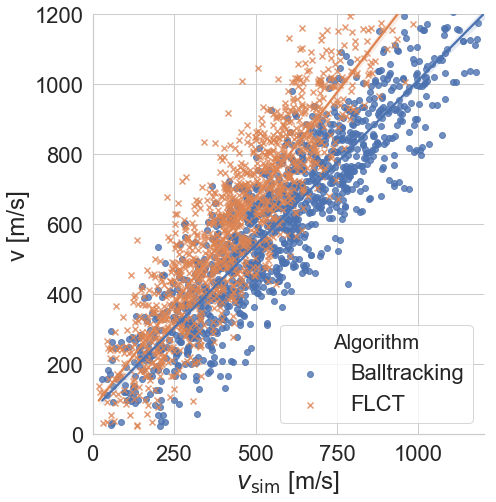

In [17]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vmag', y='vmag_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]');

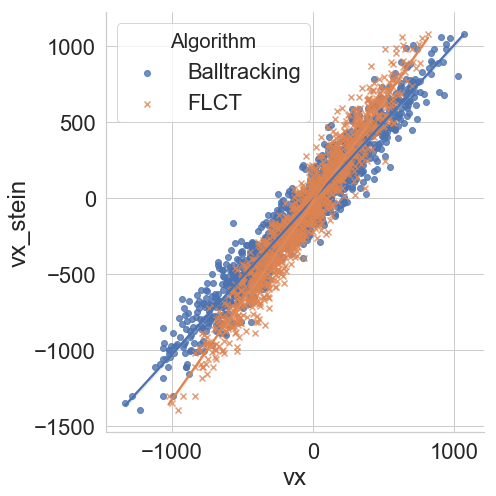

In [18]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vx', y='vx_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
#g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]')

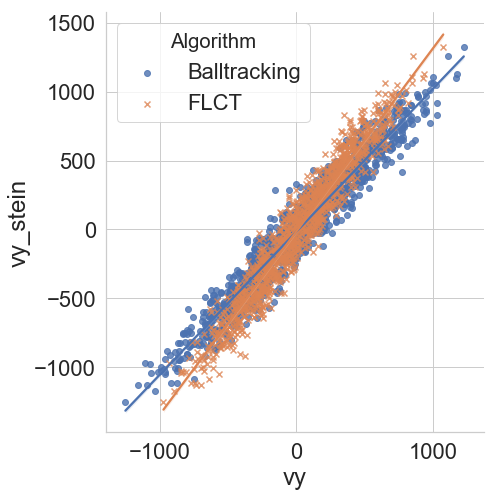

In [19]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vy', y='vy_stein', hue='Algorithm', markers=["o", "x"], height=7, legend_out=False)
#g.set(xlim=[0, 1200], ylim=[0, 1200], xlabel=r'$v_{\mathrm{sim}}$ [m/s]', ylabel='v [m/s]')

In [20]:
df1.query("nframes == 190 & FWHM==7").vx_stein.values

array([ 255.91424512,  858.89887923,  -74.84412008, ..., -855.23912037,
       -983.4940416 , -461.77644329])

In [21]:
p, r, _, _, _ = np.polyfit(df1.query("Algorithm == 'Balltracking' & nframes == 30 & FWHM==11").vx_stein.values, df1.query("Algorithm == 'Balltracking' & nframes == 30 & FWHM==11").vx.values, 1, full=True)
p

array([0.88404782, 6.00974313])

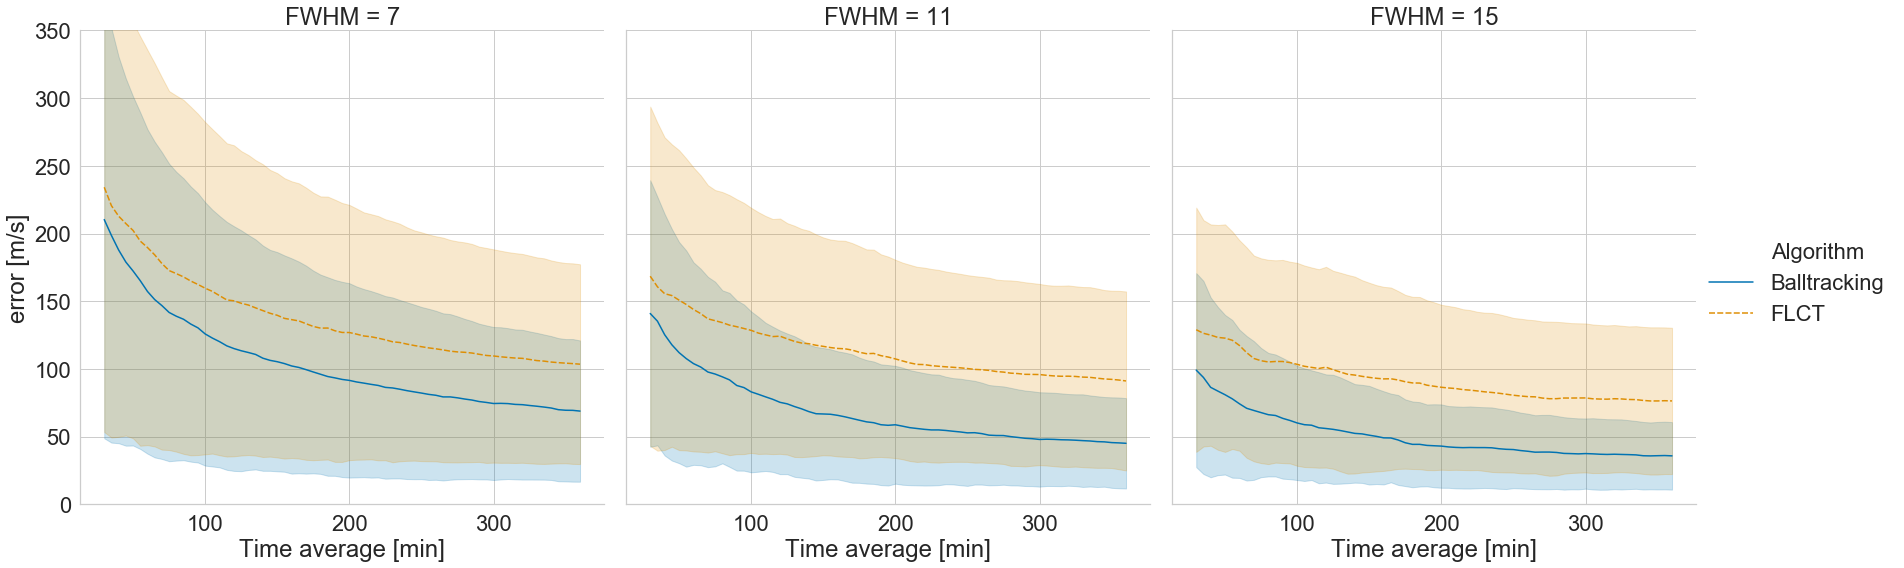

In [22]:
g1 = sns.relplot(data=df1, x='nframes', y='error',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]', ylabel='error [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'error.png'))

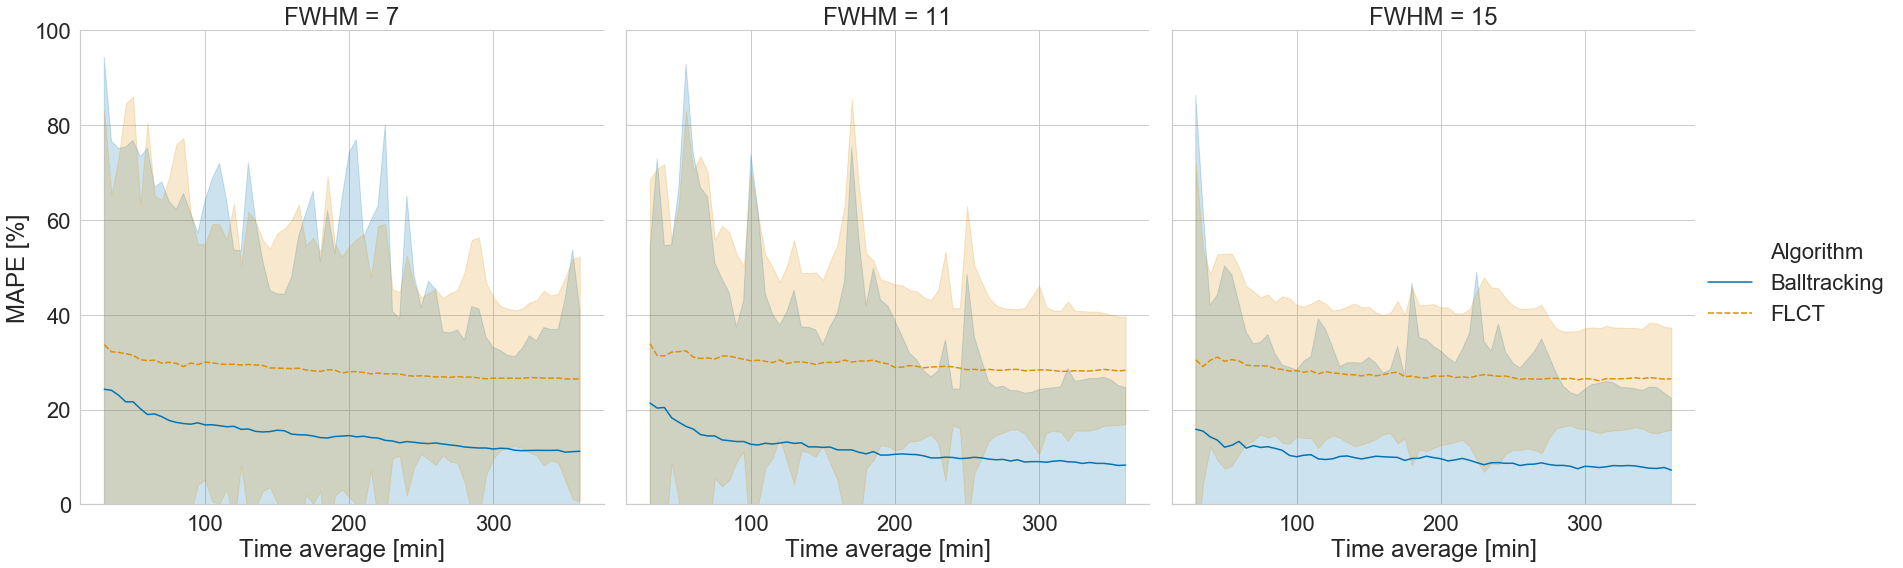

In [23]:
g1 = sns.relplot(data=df1, x='nframes', y='APE',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8, estimator=np.median)
g1.set(xlabel='Time average [min]', ylabel='MAPE [%]', ylim=[0, 100])
plt.savefig(PurePath(outputdir, 'MAPE.png'))

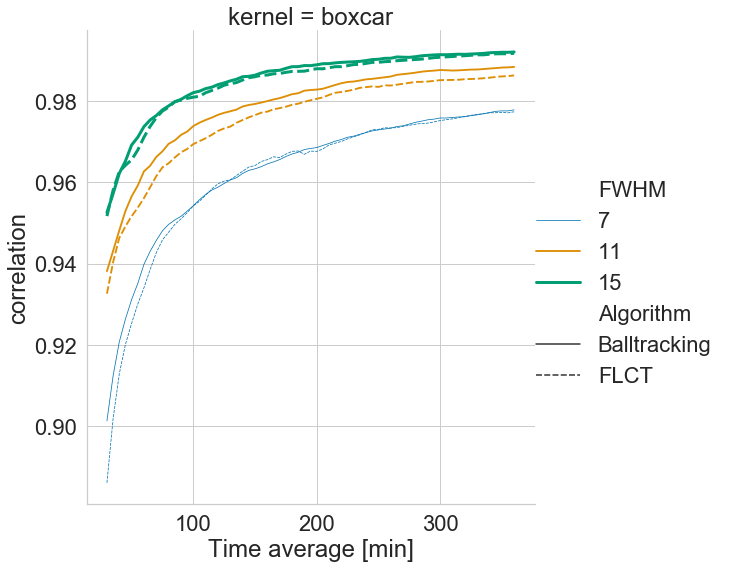

In [24]:
g1 = sns.relplot(data=df2, x='nframes', y='correlation', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]')
plt.savefig(PurePath(outputdir, 'correlation.png'))

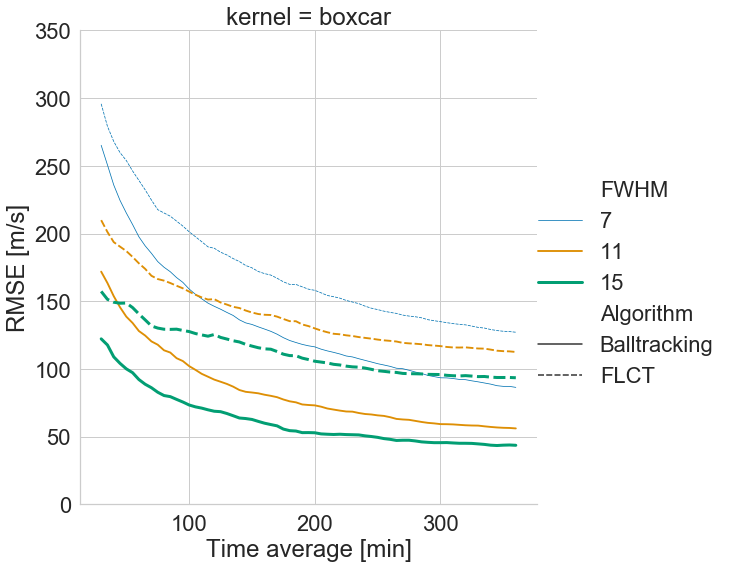

In [25]:
g2 = sns.relplot(data=df2, x='nframes', y='RMSE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g2.set(xlabel='Time average [min]', ylabel='RMSE [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'rmse.png'))


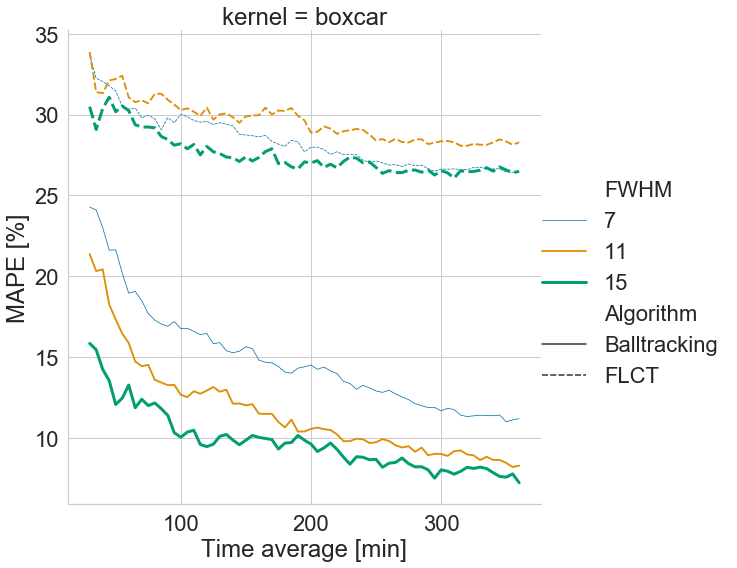

In [26]:
g3 = sns.relplot(data=df2, x='nframes', y='MAPE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g3.set(xlabel='Time average [min]', ylabel='MAPE [%]')
plt.savefig(PurePath(outputdir, 'mape.png'))

In [27]:
def hexbin(x, y, color, **kwargs):
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, mincnt=2, gridsize=(10, 30), cmap='inferno', **kwargs)
    # The number of total counts (i.e. # of independent samples) changes with the FWHM
    plt.colorbar();

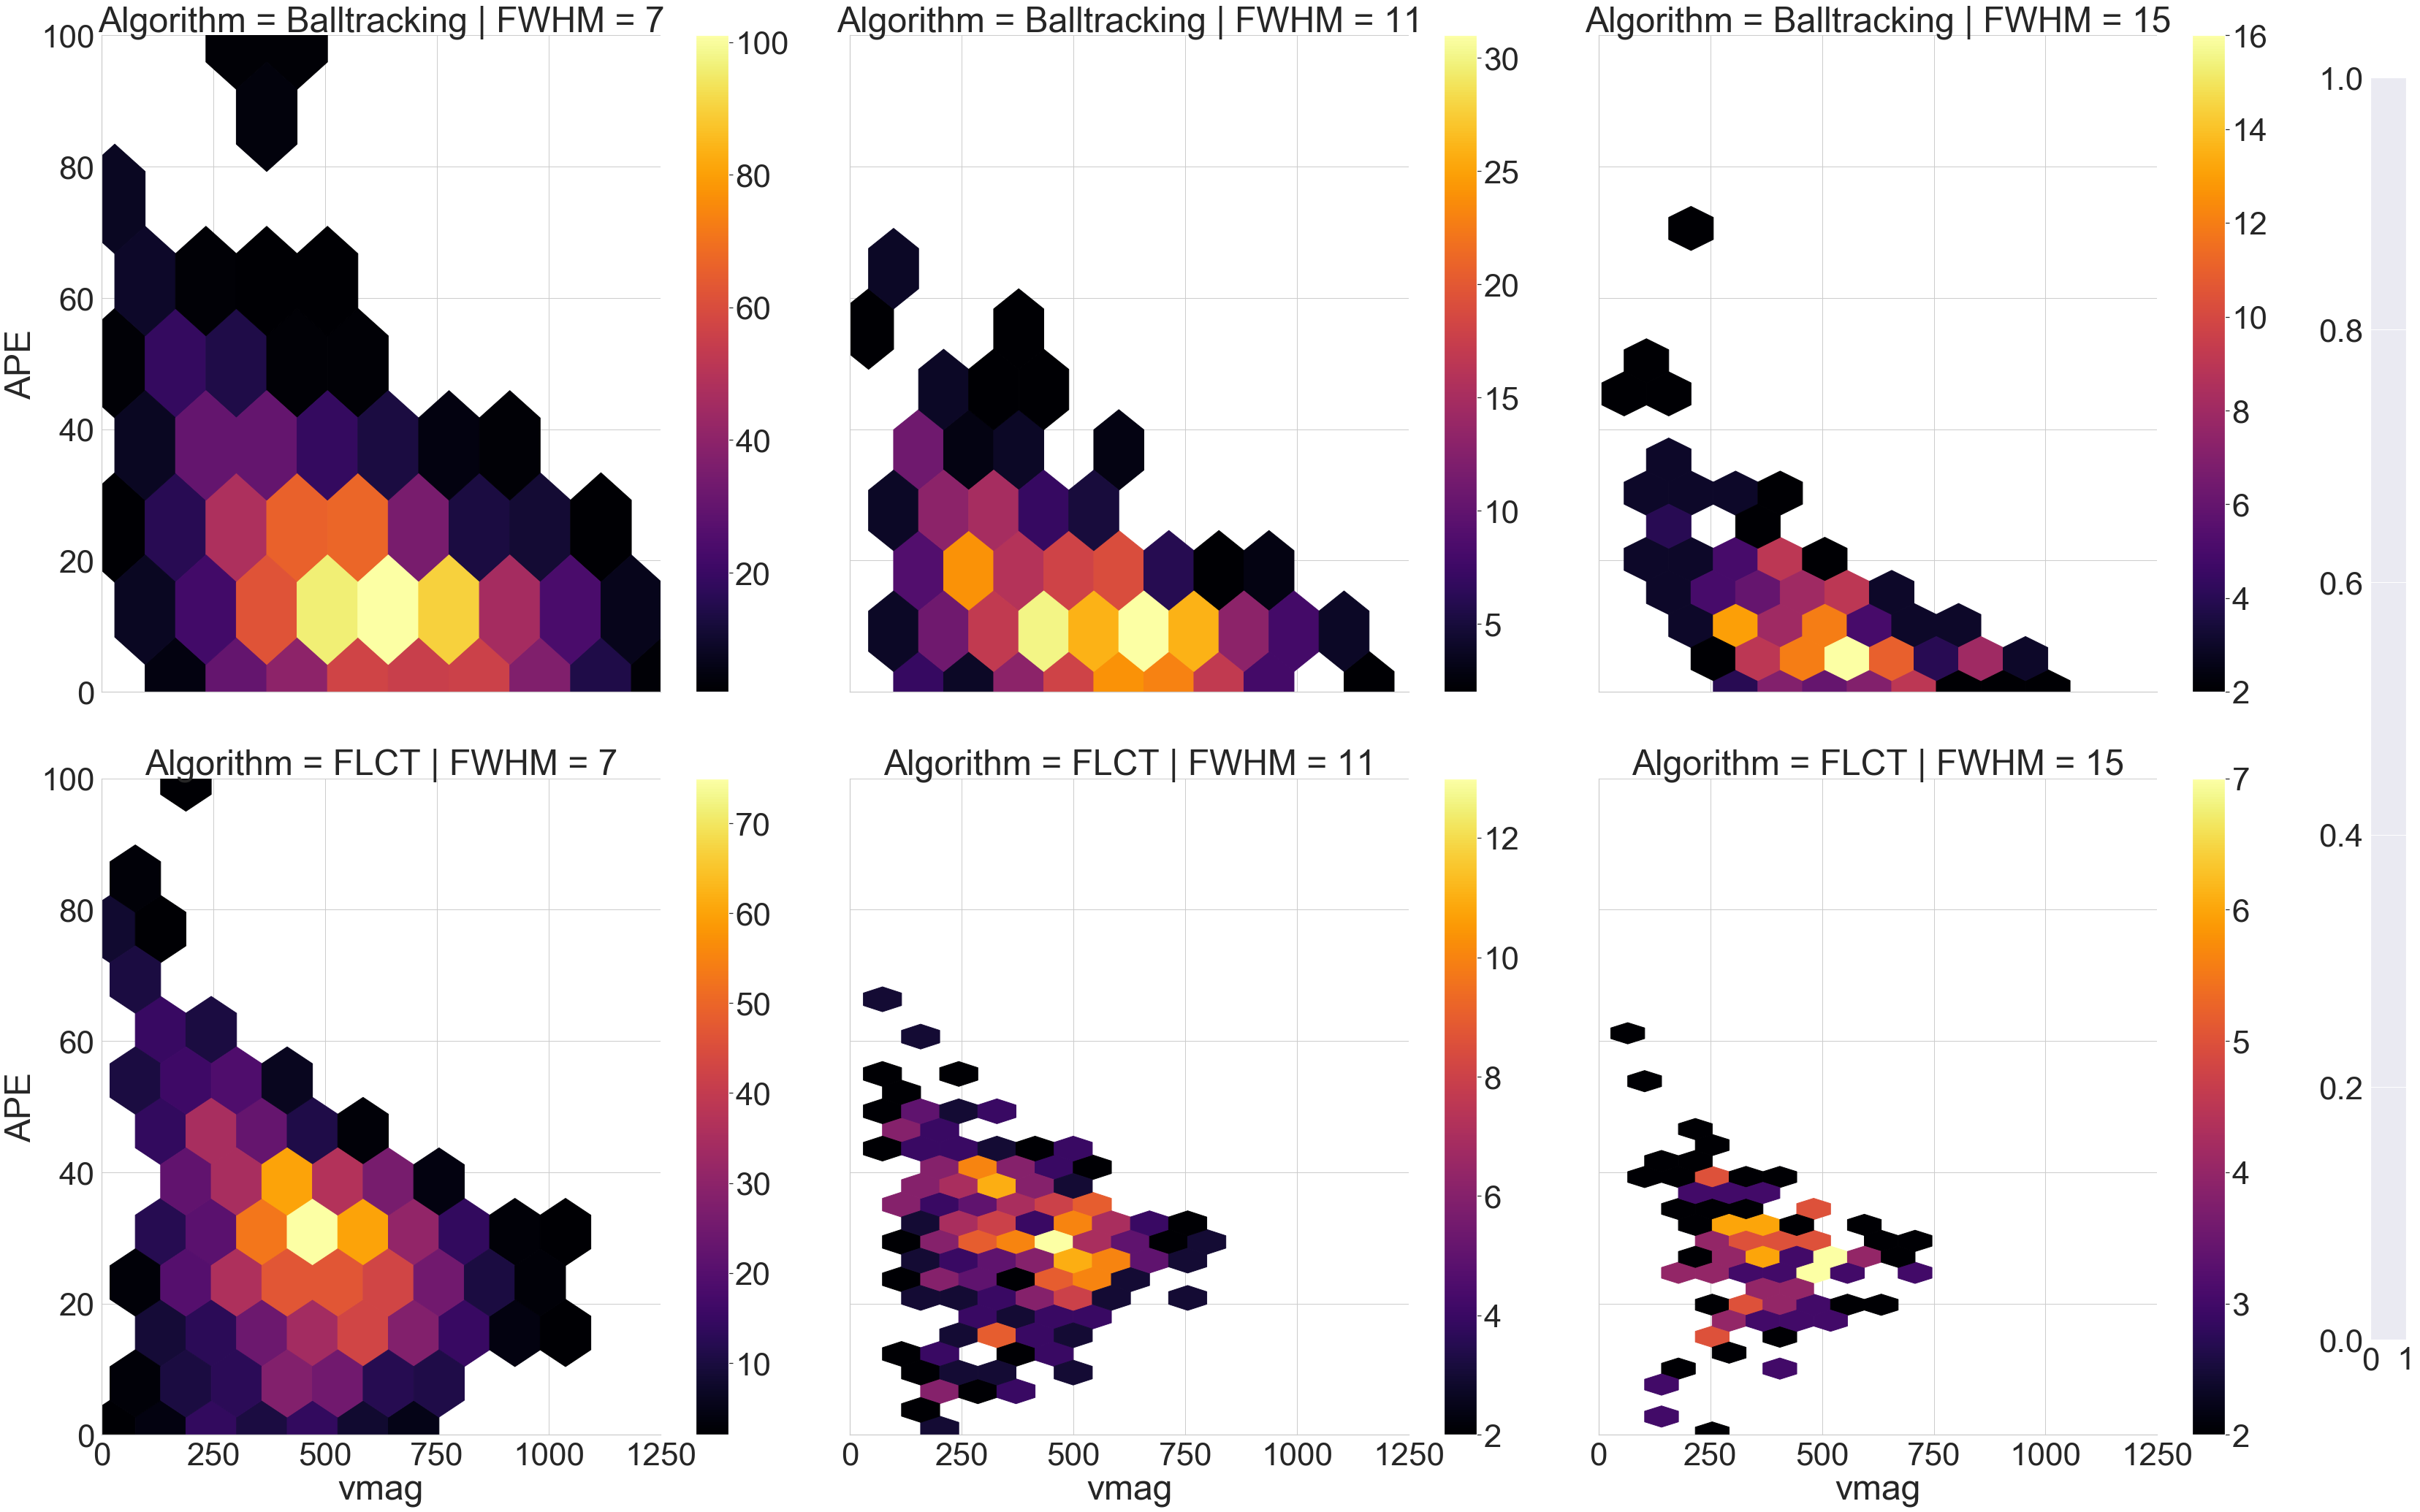

In [28]:
sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(df1.query("nframes == 190"), row='Algorithm', col='FWHM', height=15)
    
g.map(hexbin, 'vmag', 'APE');
g.set(xlim=[0, 1250], ylim=[0, 100]);
cbar_ax = g.fig.add_axes([1.015,0.13, 0.015, 0.8])

In [ ]:
g = sns.FacetGrid(df1.query("nframes == 190"), row='Algorithm', col='FWHM', height=15)
g.map(sns.distplot, 'APE', bins=50, hist_kws={"range":[0, 100]})
g.set(xlim=[0, 200])
# g.set(xlabel='APE [%]', ylabel = 'density')

for ax in g.axes.flat:
    #ax.set_ticks(ax.get_title(), fontsize='xx-large')
    # This only works for the left ylabels
    #ax.set_xticks(range(0,101, 10))
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    
g.axes[0, 0].set_ylabel('Probability density')
g.axes[1, 0].set_ylabel('Probability density')

### Drift test